# Credit Score Classification

## Importing needed libraries

In [ ]:
!pip install catboost

In [ ]:
!pip install dask[dataframe]

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------- ----------------------- 0.5/1.2 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/25.3 MB ? eta -:--:--
   - -------------------------------------- 0.8/25.3 MB 3.7 MB/s eta 0:00:07
   -- ------------------------------------- 1.3/25.3 MB 3.7 MB/s eta 0:00:07
   --- ------------------------------------ 2.1/25.3 MB 3.6 MB/s eta 0:00:07
   ---- ----------------------------------- 2.9/25.3 MB 3.6 MB/s eta 0:00:07
   ----- ---------------------------------- 3.7/25.3 MB 3.6 MB/s eta 0:00:06
   ------- -------------------------------- 4.5/25.3 MB 3.6 MB/s eta 0:00:06
   -------- ------------------------------- 5.2/25.3 MB 3.6 MB/s eta 0:00:06
   --------- ------------------------------ 6.0/25.3 MB 3.6 MB/s eta 0:00:06
   ---------- ----------------------------- 6.8/25.3 MB 3.6 MB/s eta 0:00:06
   ------------ 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, log_loss, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense






## Loading Dataset

In [ ]:
# loading the dataset 
df = pd.read_csv('train.csv')

# displaying the first rows of the dataset
df.head()

C:\Users\Karem\AppData\Local\Temp\ipykernel_24116\1087546909.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


## Exploratory Data Analysis

In [ ]:
# number of columns and rows
df.shape

(100000, 28)

In [ ]:
# dataset information including non-null count and data types
df.info()


# summary collection
numerical_summary = df.describe().transpose()    #provides summary of numerical data
categorical_summary = df.describe(include='object').transpose() #provides summary for catergorical data

# display summaries
print(numerical_summary)
print(categorical_summary)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Since it was found that the non-null values are not the same in all columns, that means that there are missing values.

In [ ]:
# Checking for missing values
df.isnull().sum().sort_values(ascending=False)



Monthly_Inhand_Salary       15002
Type_of_Loan                11408
Name                         9985
Credit_History_Age           9030
Num_of_Delayed_Payment       7002
Amount_invested_monthly      4479
Num_Credit_Inquiries         1965
Monthly_Balance              1200
ID                              0
Changed_Credit_Limit            0
Payment_Behaviour               0
Total_EMI_per_month             0
Payment_of_Min_Amount           0
Credit_Utilization_Ratio        0
Outstanding_Debt                0
Credit_Mix                      0
Delay_from_due_date             0
Customer_ID                     0
Num_of_Loan                     0
Interest_Rate                   0
Num_Credit_Card                 0
Num_Bank_Accounts               0
Annual_Income                   0
Occupation                      0
SSN                             0
Age                             0
Month                           0
Credit_Score                    0
dtype: int64

It was found that the missing values are located in the following columns: Monthly_Inhand_Salary, Type_of_Loan, Name, Credit_History_Age, Num_of_Delayed_Payment, Amount_invested_monthly, Num_Credit_Inquiries, Monthly_Balance

### Visualizing missing values

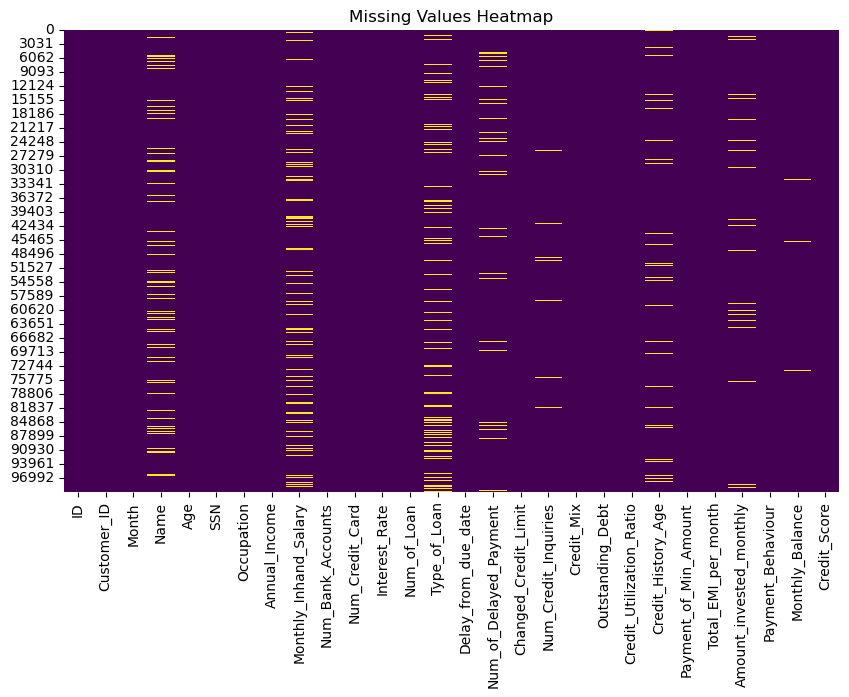

In [ ]:
# Visualizing missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


## Data Preprocessing

### Data Cleaning

#### Correcting Data Types

In [ ]:
# Convert numeric columns to correct data type, forcing errors to NaN for consistency
columns_to_convert = ['Age', 'Annual_Income', 'Num_of_Loan', 'Outstanding_Debt',
                      'Num_of_Delayed_Payment', 'Amount_invested_monthly', 'Monthly_Balance', 'Changed_Credit_Limit']

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Converting "Credit_History_Age" column to total number of months
def convert_credit_history_to_months(value):
    if pd.isnull(value):
        return None  # Handle NaN values
    try:
        years, months = 0, 0
        if "Years" in value:
            years = int(value.split("Years")[0].strip())
        if "Months" in value:
            months = int(value.split("Months")[0].split()[-1].strip())
        return years * 12 + months
    except (ValueError, AttributeError):
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_history_to_months)

In [8]:
# Rechecking data types
df.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                         float64
SSN                          object
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                 float64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                

#### Handling Missing Values

Visualizing to determine choosing mean or median for filling NaN values

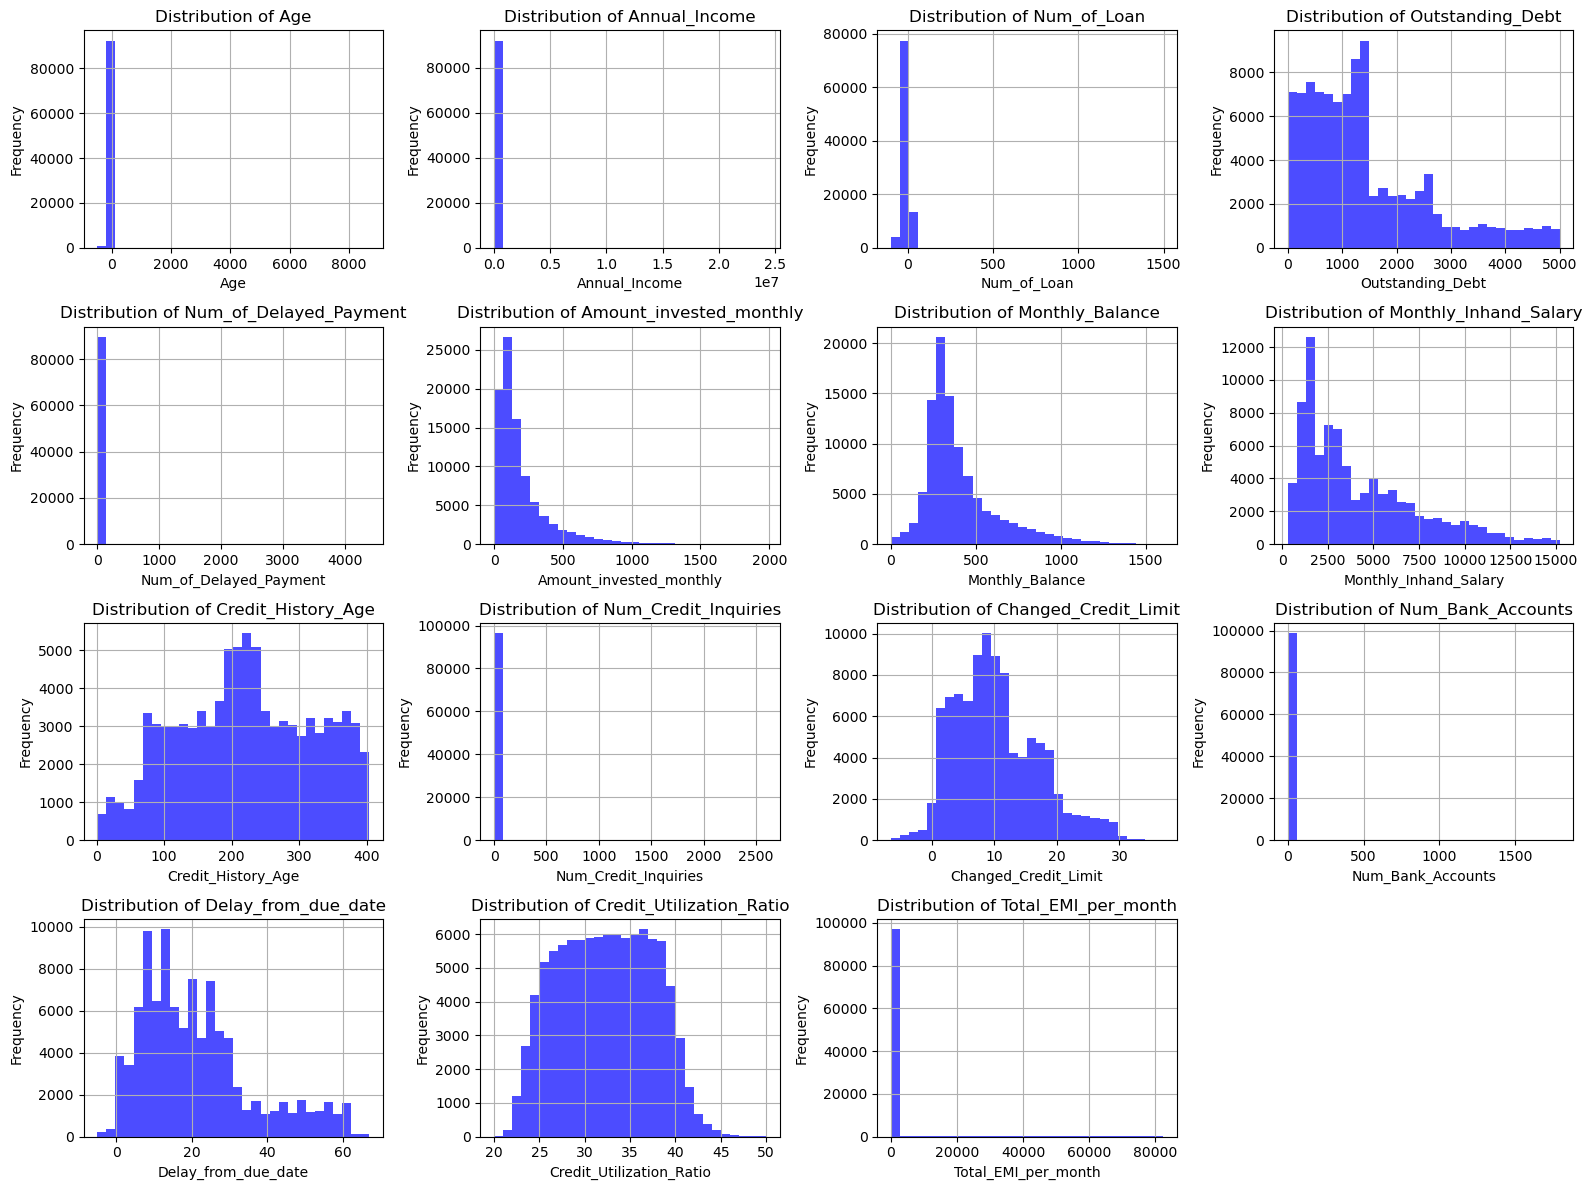

In [ ]:
numerical_columns = ['Age', 'Annual_Income', 'Num_of_Loan',
                              'Outstanding_Debt', 'Num_of_Delayed_Payment',
                              'Amount_invested_monthly', 'Monthly_Balance',
                              'Monthly_Inhand_Salary',
                              'Credit_History_Age', 'Num_Credit_Inquiries',
                              'Changed_Credit_Limit', 'Num_Bank_Accounts',
                              'Delay_from_due_date', 'Credit_Utilization_Ratio',
                              'Total_EMI_per_month',]

# Plotting histograms for each numerical column to visualize distribution
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)  
    df[col].hist(bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Since no numeric data is normally distributed I will fill NaN values using the median

In [ ]:
numerical_features_to_fill = ['Age', 'Annual_Income', 'Num_of_Loan',
                              'Outstanding_Debt', 'Num_of_Delayed_Payment',
                              'Amount_invested_monthly', 'Monthly_Balance', 'Monthly_Inhand_Salary',
                              'Credit_History_Age', 'Num_Credit_Inquiries', 'Changed_Credit_Limit']

# filling numeric NaN values with median
for col in numerical_features_to_fill:
    df[col].fillna(df[col].median(), inplace=True)

# filling categorical NaN values the mode
categorical_features_to_fill = ['Type_of_Loan', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

for col in categorical_features_to_fill:
    df[col].fillna(df[col].mode()[0], inplace=True)

C:\Users\Karem\AppData\Local\Temp\ipykernel_24116\4009585444.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\Karem\AppData\Local\Temp\ipykernel_24116\4009585444.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [11]:
# Rechecking missing values
df.isnull().sum().sort_values(ascending=False)

Name                        9985
ID                             0
Num_of_Delayed_Payment         0
Monthly_Balance                0
Payment_Behaviour              0
Amount_invested_monthly        0
Total_EMI_per_month            0
Payment_of_Min_Amount          0
Credit_History_Age             0
Credit_Utilization_Ratio       0
Outstanding_Debt               0
Credit_Mix                     0
Num_Credit_Inquiries           0
Changed_Credit_Limit           0
Delay_from_due_date            0
Customer_ID                    0
Type_of_Loan                   0
Num_of_Loan                    0
Interest_Rate                  0
Num_Credit_Card                0
Num_Bank_Accounts              0
Monthly_Inhand_Salary          0
Annual_Income                  0
Occupation                     0
SSN                            0
Age                            0
Month                          0
Credit_Score                   0
dtype: int64

#### Dropping Irrelevant Columns

In [ ]:
# dropping unnecessary columns that are not relevant for predicting Credit Score
columns_to_drop = ['ID', 'Customer_ID', 'Name', 'SSN', 'Month']

df.drop(columns=columns_to_drop, inplace=True)

df.head()


,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,23.0,Scientist,19114.12,3093.745000,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,...,Good,809.98,31.944960,219.0,No,49.574949,118.280222,Low_spent_Large_value_payments,284.629162,Good
2,-500.0,Scientist,19114.12,3093.745000,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,Low_spent_Medium_value_payments,331.209863,Good
3,23.0,Scientist,19114.12,3093.745000,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,...,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
4,23.0,Scientist,19114.12,1824.843333,3,4,3,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,...,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good


### Encoding Categorical Features and Target

In [ ]:
# Group rare loan types into "Other"
threshold = 0.01  # Categories representing less than 1% of the data
loan_type_counts = df['Type_of_Loan'].value_counts(normalize=True)
rare_loan_types = loan_type_counts[loan_type_counts < threshold].index
df['Type_of_Loan'] = df['Type_of_Loan'].replace(rare_loan_types, 'Other')


categorical_columns = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Type_of_Loan']

df_enc= df.copy()

# Appling label encoding to categorical columns
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df_enc[col] = label_encoders[col].fit_transform(df_enc[col])

# Label encoding the target variable 'Credit_Score'
label_encoder = LabelEncoder()
df_enc['Credit_Score'] = label_encoder.fit_transform(df_enc['Credit_Score'])

df_enc.head()


,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,23.0,12,19114.12,1824.843333,3,4,3,4.0,6,3,...,3,809.98,26.822620,265.0,1,49.574949,80.415295,3,312.494089,0
1,23.0,12,19114.12,3093.745000,3,4,3,4.0,6,-1,...,1,809.98,31.944960,219.0,1,49.574949,118.280222,4,284.629162,0
2,-500.0,12,19114.12,3093.745000,3,4,3,4.0,6,3,...,1,809.98,28.609352,267.0,1,49.574949,81.699521,5,331.209863,0
3,23.0,12,19114.12,3093.745000,3,4,3,4.0,6,5,...,1,809.98,31.377862,268.0,1,49.574949,199.458074,6,223.451310,0
4,23.0,12,19114.12,1824.843333,3,4,3,4.0,6,6,...,1,809.98,24.797347,269.0,1,49.574949,41.420153,2,341.489231,0


### Handling Outliers

In [ ]:
# Create a copy of the dataset to display outliers before treatment
data_before_outlier_treatment = df_enc.copy()

# Calculating upper and lower bounds
for col in numerical_features_to_fill:
    q1 = df_enc[col].quantile(0.25)
    q3 = df_enc[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_enc[col] = df_enc[col].clip(lower=lower_bound, upper=upper_bound)




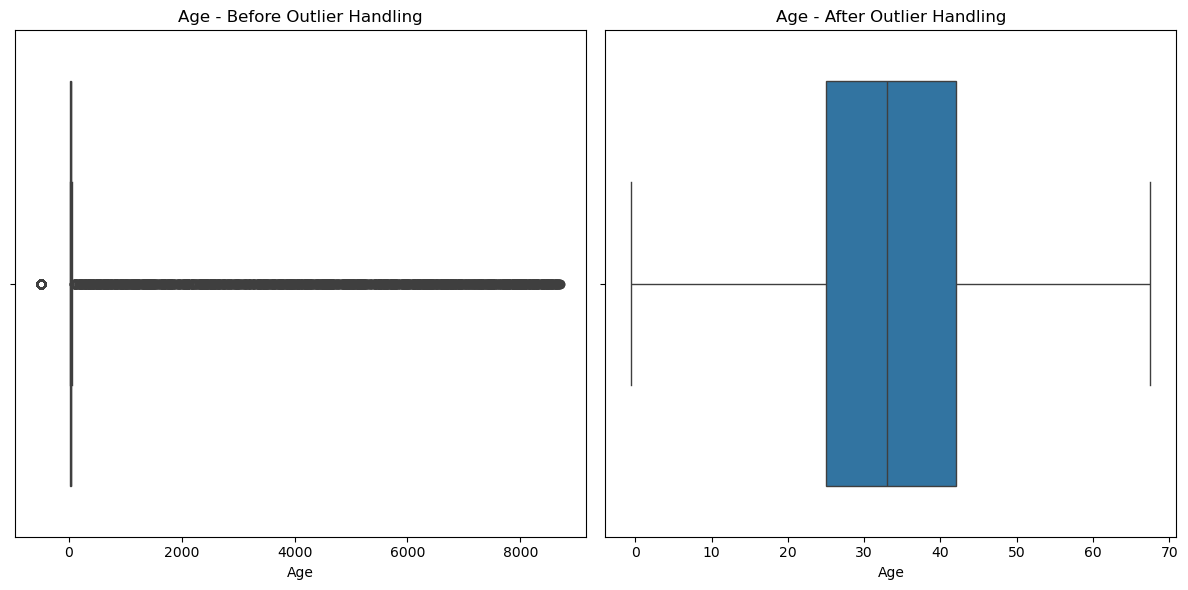

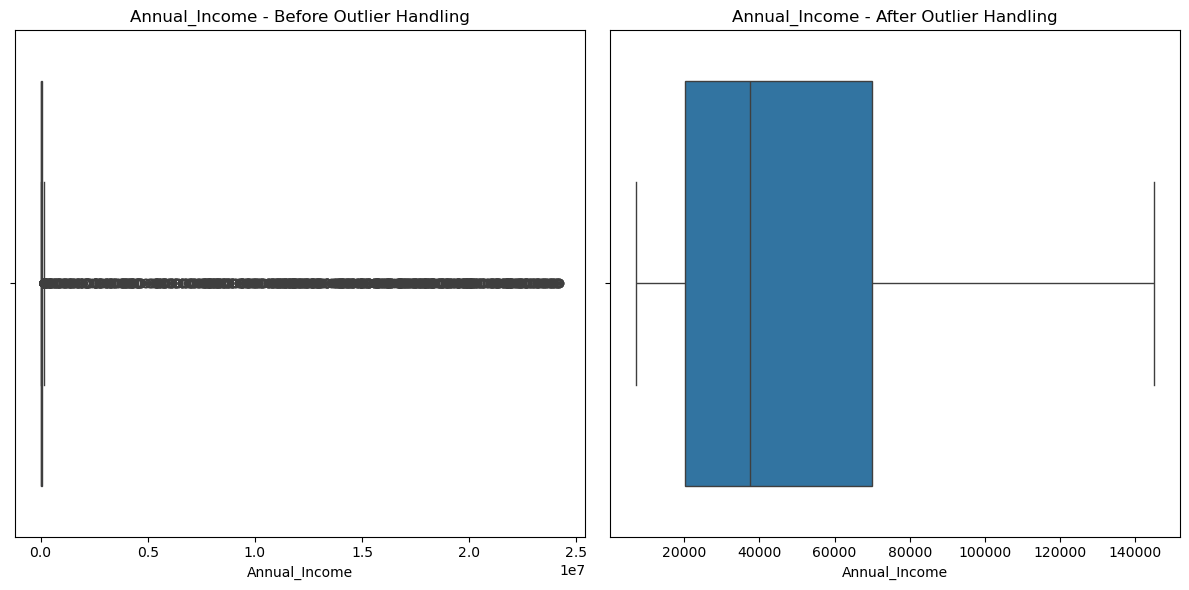

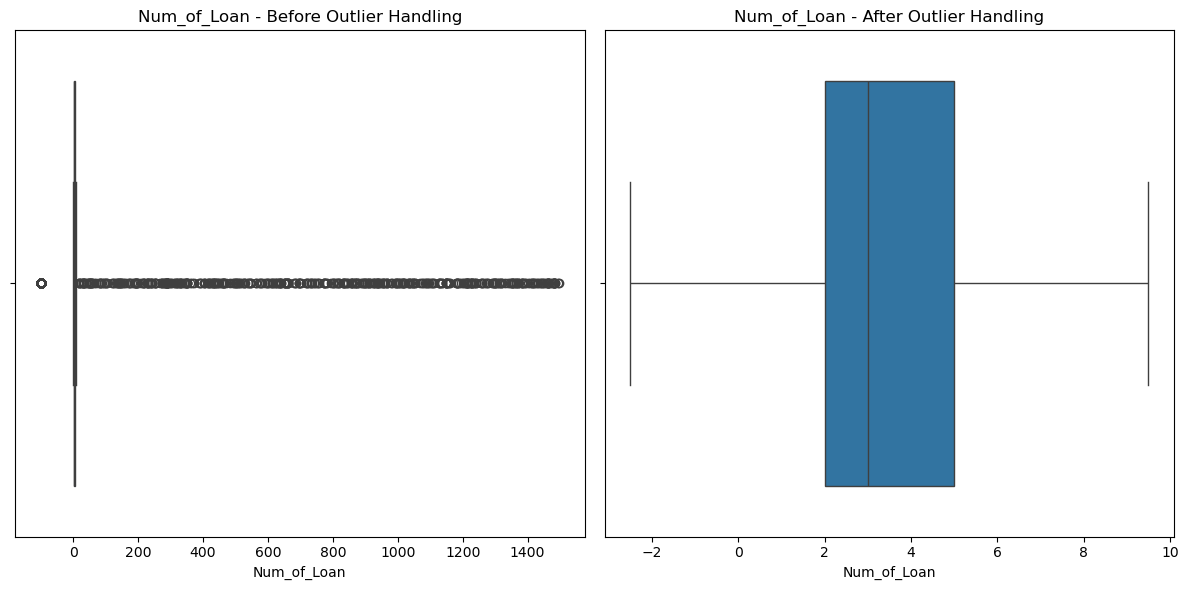

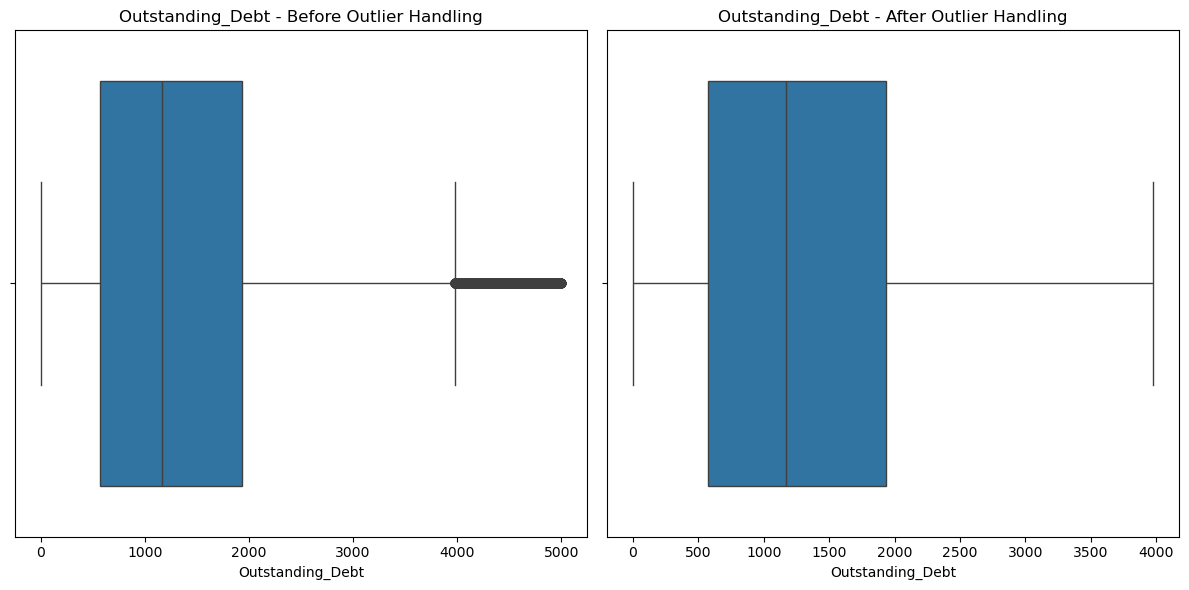

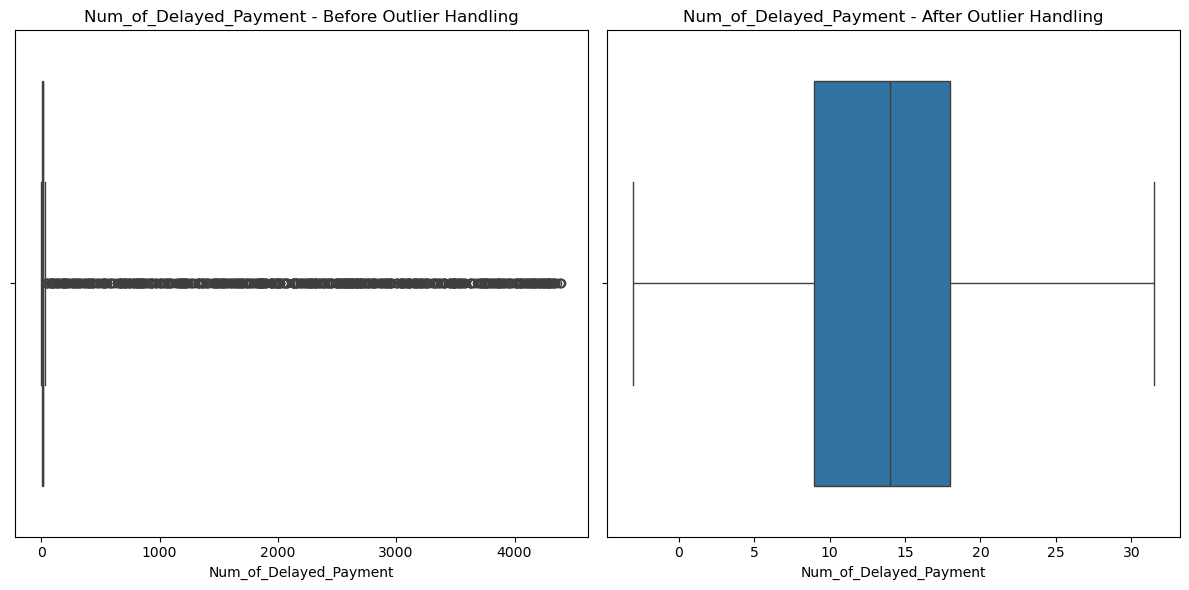

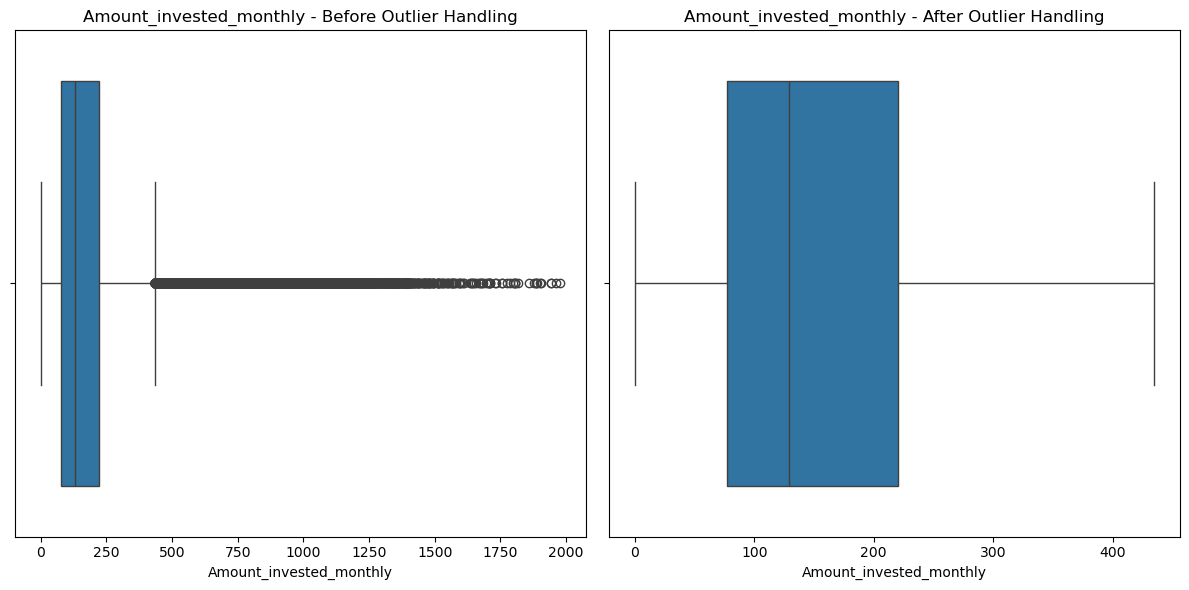

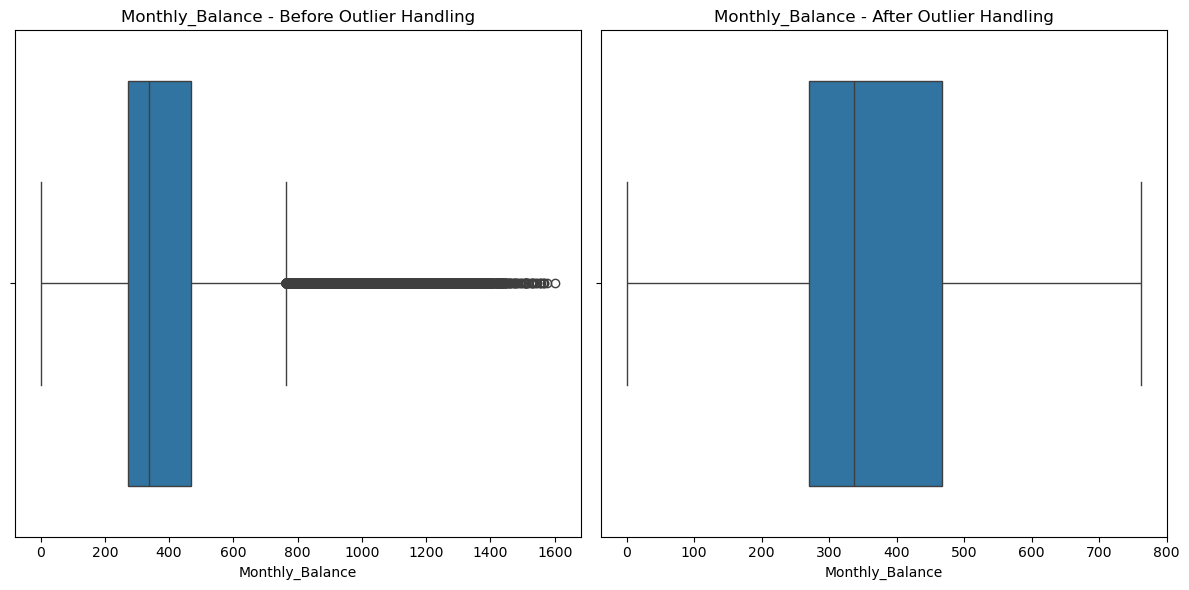

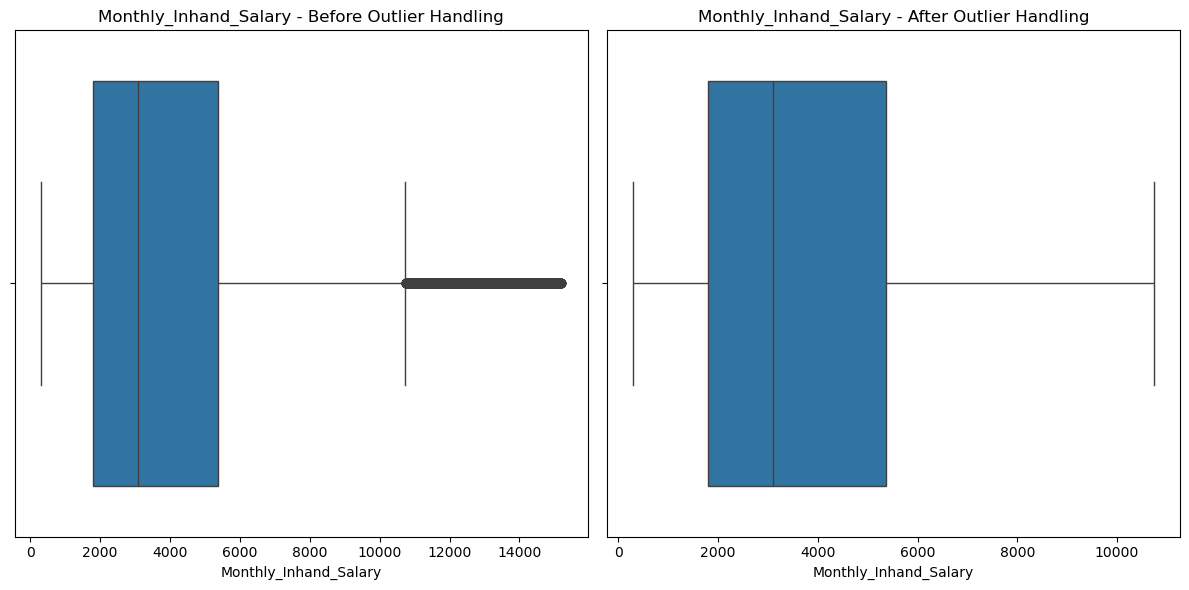

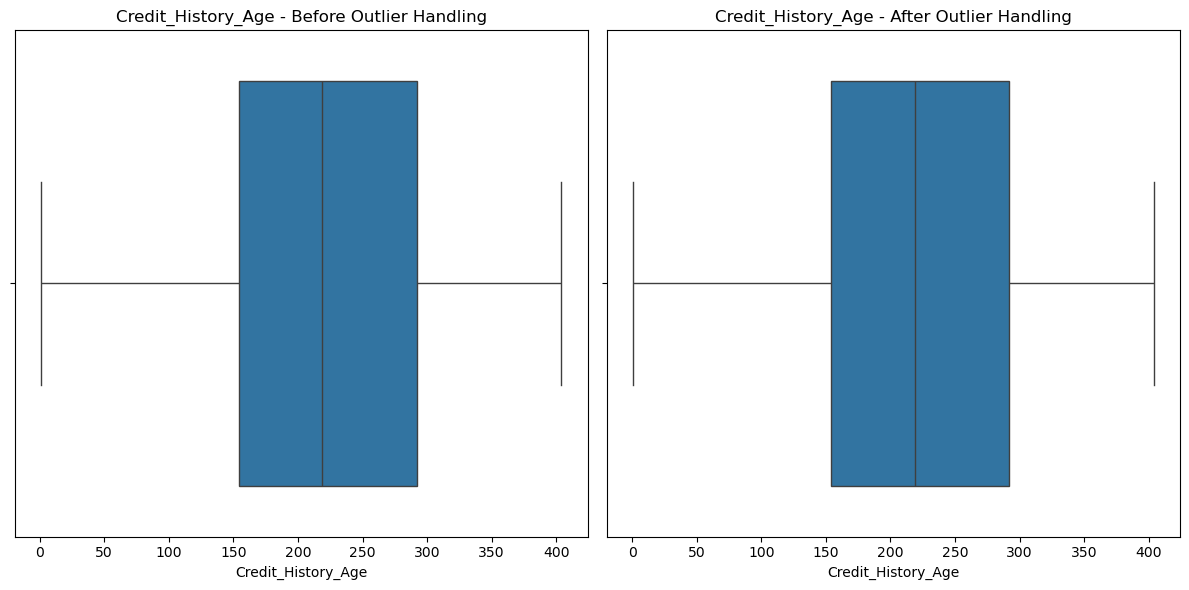

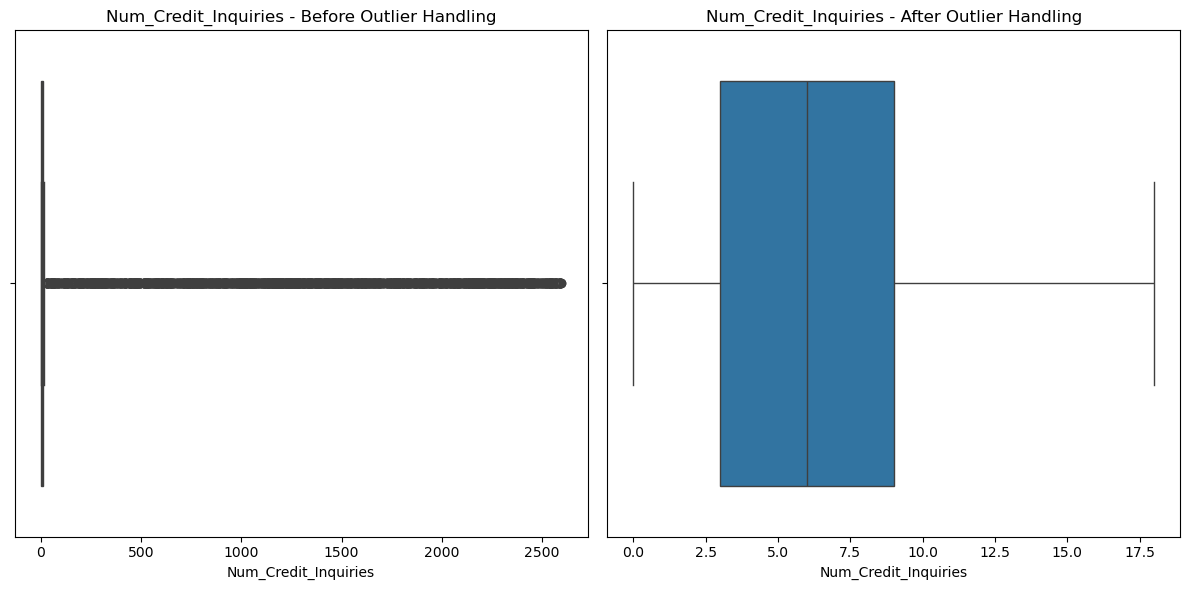

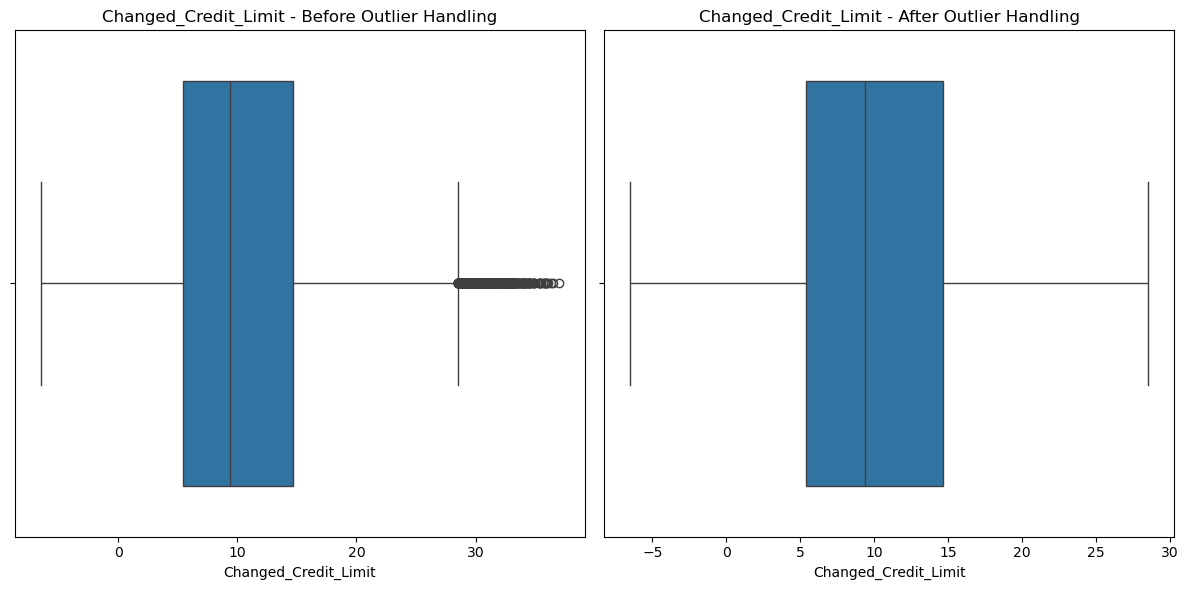

In [15]:
# Visualize before and after outlier treatment
for col in numerical_features_to_fill:
    plt.figure(figsize=(12, 6))

    # Before handling outliers
    plt.subplot(1, 2, 1)
    sns.boxplot(x=data_before_outlier_treatment[col])
    plt.title(f'{col} - Before Outlier Handling')

    # After handling outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_enc[col])
    plt.title(f'{col} - After Outlier Handling')

    plt.tight_layout()
    plt.show()


### Feature Engineering

After Observing previous notebooks, it was found that it was useful to create the new features: 'Debt_to_Income_Ratio' and 'Income_per_Loan', as they provide meaningful insights towards credit score.

In [ ]:
# Create 'Debt_to_Income_Ratio' and 'Income_per_Loan' features
df_enc['Debt_to_Income_Ratio'] = df_enc['Outstanding_Debt'] / (df_enc['Annual_Income'] + 1)  
df_enc['Income_per_Loan'] = df_enc['Annual_Income'] / (df_enc['Num_of_Loan'] + 1)  


### Standardizing Numerical Features

In [ ]:
# Standardizing numerical features 

numerical_columns.extend(['Debt_to_Income_Ratio', 'Income_per_Loan'])

scaler = StandardScaler()
df_enc[numerical_columns] = scaler.fit_transform(df_enc[numerical_columns])

df_enc.head()


,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,...,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Debt_to_Income_Ratio,Income_per_Loan
0,-0.902753,12,-0.83922,-0.773146,-0.120024,4,3,0.264532,6,-1.215932,...,-1.067562,0.462540,1,-0.16296,-0.712129,3,-0.431616,0,-0.183717,-0.480516
1,-0.902753,12,-0.83922,-0.313004,-0.120024,4,3,0.264532,6,-1.485110,...,-0.066489,-0.020993,1,-0.16296,-0.401619,4,-0.592777,0,-0.183717,-0.480516
2,-2.900785,12,-0.83922,-0.313004,-0.120024,4,3,0.264532,6,-1.215932,...,-0.718376,0.483563,1,-0.16296,-0.701598,5,-0.323370,0,-0.183717,-0.480516
3,-0.902753,12,-0.83922,-0.313004,-0.120024,4,3,0.264532,6,-1.081342,...,-0.177318,0.494075,1,-0.16296,0.264079,6,-0.946609,0,-0.183717,-0.480516
4,-0.902753,12,-0.83922,-0.773146,-0.120024,4,3,0.264532,6,-1.014048,...,-1.463366,0.504586,1,-0.16296,-1.031908,2,-0.263917,0,-0.183717,-0.480516


# Tree-based Models

## CatBoost

Since Catboost was the best model chosen by other notebooks handling this dataset, I have decided to implement it with and without hyperparameter tuning for comparison alongside other models.

### Catboost Without Hyperparameter Tuning

In [ ]:

X = df_enc.drop('Credit_Score', axis=1)
y = df_enc['Credit_Score']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train CatBoost model
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=200)
cat_model.fit(X_train, y_train, cat_features=categorical_columns, eval_set=(X_test, y_test), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0340529	test: 1.0344005	best: 1.0344005 (0)	total: 105ms	remaining: 1m 44s
200:	learn: 0.6377838	test: 0.6629775	best: 0.6629775 (200)	total: 22.6s	remaining: 1m 29s
400:	learn: 0.6057529	test: 0.6461527	best: 0.6461527 (400)	total: 44.5s	remaining: 1m 6s
600:	learn: 0.5806800	test: 0.6344630	best: 0.6344630 (600)	total: 1m 6s	remaining: 44.2s
800:	learn: 0.5597495	test: 0.6256614	best: 0.6256614 (800)	total: 1m 28s	remaining: 22.1s
999:	learn: 0.5402729	test: 0.6192600	best: 0.6192400 (997)	total: 1m 51s	remaining: 0us

bestTest = 0.6192400313
bestIteration = 997

Shrink model to first 998 iterations.


### Classification Report for Catboost Without Hyperparameter Tuning

In [ ]:

# Predict on the test set
y_pred = cat_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.7401
              precision    recall  f1-score   support

           0       0.65      0.67      0.66      3527
           1       0.75      0.71      0.73      5874
           2       0.76      0.78      0.77     10599

    accuracy                           0.74     20000
   macro avg       0.72      0.72      0.72     20000
weighted avg       0.74      0.74      0.74     20000



### CatBoost with Hyperparameter Tuning using GridSearch

In [ ]:

# Define parameter grid
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [500, 1000]
}

# Initialize CatBoost with GridSearch
grid_search = GridSearchCV(estimator=CatBoostClassifier(cat_features=categorical_columns, verbose=0),
                           param_grid=param_grid, scoring='accuracy', cv=3)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)


{'depth': 8, 'iterations': 1000, 'learning_rate': 0.2}


### Classification Report and ROC-AUC Score for Catboost With Hyperparameter Tuning

In [ ]:

# Use the best model found by GridSearchCV
best_cat_model = grid_search.best_estimator_

# Predictions
y_pred = best_cat_model.predict(X_test)

# Evaluation metrics with class names
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("ROC-AUC Score:", roc_auc_score(pd.get_dummies(y_test), best_cat_model.predict_proba(X_test)))


              precision    recall  f1-score   support

        Good       0.72      0.69      0.70      3527
        Poor       0.77      0.75      0.76      5874
    Standard       0.78      0.80      0.79     10599

    accuracy                           0.77     20000
   macro avg       0.76      0.75      0.75     20000
weighted avg       0.77      0.77      0.77     20000

ROC-AUC Score: 0.8963571473561038


It was noticed that the implemented model in this not book had a lower precision than the previous notebooks. That is due to limiting the 'Type_of_Loan' encoding to encode only the most common types where others were marked as other.

In [ ]:
# Listing feature importances
best_cat_model.get_feature_importance(prettified=True)


,Feature Id,Importances
0,Outstanding_Debt,8.479517
1,Delay_from_due_date,7.050206
2,Interest_Rate,7.010404
3,Changed_Credit_Limit,6.882531
4,Credit_History_Age,5.752307
5,Total_EMI_per_month,5.674188
6,Age,5.624207
7,Num_Credit_Card,5.115704
8,Num_Bank_Accounts,4.358355
9,Debt_to_Income_Ratio,4.323276


## Data Resampling

Checking if data resampling is needed

In [ ]:
# count of unique values in the 'Credit_Score' column
credit_score_counts = df_enc['Credit_Score'].value_counts()

# Display the counts
print(credit_score_counts)
# {'Good': 0, 'Poor': 1, 'Standard': 2}


Credit_Score
2    53174
1    28998
0    17828
Name: count, dtype: int64


In [27]:
label_encoder.classes_

array(['Good', 'Poor', 'Standard'], dtype=object)

Decided to Up-sample minority class 0 'Good' and down-sample Majority class 2 'Standard' to balance with middle class 1 'Poor'

In [ ]:

# Separate the dataframe by class
class_0 = df_enc[df_enc['Credit_Score'] == 0]  # 'Good'
class_1 = df_enc[df_enc['Credit_Score'] == 1]  # 'Poor'
class_2 = df_enc[df_enc['Credit_Score'] == 2]  # 'Standard'

# assigning the target sample size 
target_size = len(class_1)

# Down-sample the majority class (2 - 'Standard') to match the middle class
class_2_downsampled = resample(class_2, replace=False, n_samples=target_size, random_state=42)

# Up-sample the minority class (0 - 'Good') to match the middle class
class_0_upsampled = resample(class_0, replace=True, n_samples=target_size, random_state=42)

# Combine resampled classes
df_resampled = pd.concat([class_1, class_2_downsampled, class_0_upsampled])

# Shuffle dataset
df_resampled = df_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Recheckng class distribution
print(df_resampled['Credit_Score'].value_counts())


Credit_Score
2    28998
1    28998
0    28998
Name: count, dtype: int64


## Splitting the Dataset to Train and Test

In [ ]:

# Assigning X and y
X = df_resampled.drop('Credit_Score', axis=1)  
y = df_resampled['Credit_Score'] 

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Random Forest Classifier (Ensemble Learning)

In [ ]:

# Training the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluating the model
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        Good       0.84      0.96      0.89      5799
        Poor       0.83      0.86      0.84      5800
    Standard       0.84      0.69      0.75      5800

    accuracy                           0.83     17399
   macro avg       0.83      0.83      0.83     17399
weighted avg       0.83      0.83      0.83     17399



## XGBoost Classifier

In [ ]:

# Training the model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluating the model
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


c:\Users\Karem\miniconda3\envs\KarimML\lib\site-packages\xgboost\core.py:158: UserWarning: [03:59:36] WARNING: D:\bld\xgboost-split_1733179550881\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

        Good       0.78      0.90      0.83      5799
        Poor       0.80      0.82      0.81      5800
    Standard       0.77      0.64      0.70      5800

    accuracy                           0.78     17399
   macro avg       0.78      0.78      0.78     17399
weighted avg       0.78      0.78      0.78     17399



## Gradient Boosting Classifier

In [ ]:

# Training the model
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Evaluating the model
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        Good       0.71      0.84      0.77      5799
        Poor       0.76      0.77      0.76      5800
    Standard       0.70      0.58      0.63      5800

    accuracy                           0.73     17399
   macro avg       0.73      0.73      0.72     17399
weighted avg       0.73      0.73      0.72     17399



## LightGBM Classifier

In [ ]:
# Replacing unwanted spaces in column names with '_'
X_train.columns = [col.replace(' ', '_') for col in X_train.columns]
X_test.columns = [col.replace(' ', '_') for col in X_test.columns]

In [ ]:

# Training the model
lgbm = LGBMClassifier(force_row_wise=True, random_state=42)
lgbm.fit(X_train, y_train)

# Evaluating the model
y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Total Bins 3792
[LightGBM] [Info] Number of data points in the train set: 69595, number of used features: 24
[LightGBM] [Info] Start training from score -1.098584
[LightGBM] [Info] Start training from score -1.098627
[LightGBM] [Info] Start training from score -1.098627
              precision    recall  f1-score   support

           0       0.73      0.87      0.79      5799
           1       0.78      0.79      0.78      5800
           2       0.74      0.59      0.65      5800

    accuracy                           0.75     17399
   macro avg       0.75      0.75      0.74     17399
weighted avg       0.75      0.75      0.74     17399



# Not Tree-Based Models

## One-Hot Encoding

In [ ]:
categorical_columns = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Type_of_Loan']

# One-hot encoding
df_one_hot = pd.get_dummies(df_resampled, columns=categorical_columns)

# Display resulting data
df_one_hot.head()


,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Type_of_Loan_0,Type_of_Loan_1,Type_of_Loan_2,Type_of_Loan_3,Type_of_Loan_4,Type_of_Loan_5,Type_of_Loan_6,Type_of_Loan_7,Type_of_Loan_8,Type_of_Loan_9
0,-0.562663,-0.589144,-0.647425,-0.094471,3,8,-0.871440,-0.206512,0.889066,1.011072,...,False,False,False,True,False,False,False,False,False,False
1,0.627654,-0.291590,-0.313004,-0.085953,7,22,-0.114125,1.745031,0.564800,0.509085,...,False,False,False,False,False,False,True,False,False,False
2,0.457609,1.877201,2.023910,-0.102988,5,17,0.264532,0.197255,0.078400,-1.211157,...,False,False,False,False,False,False,True,False,False,False
3,0.967744,1.024959,1.187661,-0.111506,5,4021,-1.250097,-0.744869,0.078400,-0.712167,...,False,False,False,False,False,True,False,False,False,False
4,0.202541,2.575459,2.460008,-0.102988,5,6,-0.871440,-0.408396,-0.894398,-0.150241,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
# Convert label-encoded target variable to one-hot encoding
one_hot_encoded_target = pd.get_dummies(df_resampled['Credit_Score'], prefix='Credit_Score')

# Adding the one-hot encoded columns back to the datafrme
df_one_hot = pd.concat([df_one_hot, one_hot_encoded_target], axis=1)


In [ ]:
# Renaming the columns to reflect class names
df_one_hot = df_one_hot.rename(columns={
    'Credit_Score_0': 'Credit_Score_Good',
    'Credit_Score_1': 'Credit_Score_Poor',
    'Credit_Score_2': 'Credit_Score_Standard'
})


In [39]:
df_one_hot.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Type_of_Loan_3,Type_of_Loan_4,Type_of_Loan_5,Type_of_Loan_6,Type_of_Loan_7,Type_of_Loan_8,Type_of_Loan_9,Credit_Score_Good,Credit_Score_Poor,Credit_Score_Standard
0,-0.562663,-0.589144,-0.647425,-0.094471,3,8,-0.871440,-0.206512,0.889066,1.011072,...,True,False,False,False,False,False,False,False,False,True
1,0.627654,-0.291590,-0.313004,-0.085953,7,22,-0.114125,1.745031,0.564800,0.509085,...,False,False,False,True,False,False,False,False,True,False
2,0.457609,1.877201,2.023910,-0.102988,5,17,0.264532,0.197255,0.078400,-1.211157,...,False,False,False,True,False,False,False,True,False,False
3,0.967744,1.024959,1.187661,-0.111506,5,4021,-1.250097,-0.744869,0.078400,-0.712167,...,False,False,True,False,False,False,False,False,False,True
4,0.202541,2.575459,2.460008,-0.102988,5,6,-0.871440,-0.408396,-0.894398,-0.150241,...,False,False,False,False,False,False,False,True,False,False


## Logistic Regression

In [ ]:

# Split Data to features 'X' and target 'y'
X = df_one_hot.drop(['Credit_Score','Credit_Score_Good', 'Credit_Score_Poor', 'Credit_Score_Standard'], axis=1) 
y = df_one_hot['Credit_Score']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        Good       0.68      0.83      0.75      5801
        Poor       0.72      0.66      0.69      5758
    Standard       0.64      0.55      0.59      5840

    accuracy                           0.68     17399
   macro avg       0.68      0.68      0.68     17399
weighted avg       0.68      0.68      0.68     17399



c:\Users\Karem\miniconda3\envs\KarimML\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## k-Nearest Neighbors (k-NN) (Instance-Based Learning)

In [ ]:

# Training kNN model
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust 'n_neighbors' as needed
knn.fit(X_train, y_train)

# Predict
y_pred = knn.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        Good       0.71      0.89      0.79      5801
        Poor       0.78      0.78      0.78      5758
    Standard       0.74      0.55      0.63      5840

    accuracy                           0.74     17399
   macro avg       0.74      0.74      0.73     17399
weighted avg       0.74      0.74      0.73     17399



## Neural Networks

In [ ]:

# Split Data to features 'X' and target 'y'
X = df_one_hot.drop(['Credit_Score','Credit_Score_Good', 'Credit_Score_Poor', 'Credit_Score_Standard'], axis=1)  # Drop one-hot target
y = df_one_hot[['Credit_Score_Good', 'Credit_Score_Poor', 'Credit_Score_Standard']]  # one-hot target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert input features (X) and target (y) to NumPy arrays (fixes error when running with vscode when it comes to data types, runs normally without it on colab)
X_train = np.array(X_train).astype(np.float64)
X_test = np.array(X_test).astype(np.float64)
y_train = np.array(y_train).astype(np.float64)
y_test = np.array(y_test).astype(np.float64)

# Define the Neural Network
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Output layer matches one-hot encoding
])

# Compile model
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()

# Train model
mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               7680      
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 3)                 195       
                                                                 
Total params: 16,131
Trainable params: 16,131
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2175/2175 [==============================] - 6s 3ms/step - loss: 1.4737 - accuracy: 0.6746 - val_loss: 0.8254 - val_accuracy: 0.6875
Epoch 2/10
2175/2175 [==============================] - 6s 3ms/step - loss: 0.8636 - accuracy: 0.6976 - val_loss: 0.7879 - val_accuracy: 0.6995
Epoch 3/10
2175/2175 [====

# Random Forest Classifier with Hyperparameter Tuning

## Re-Splitting to avoid using previous X and y values

In [ ]:

# Separate features 'X' and target variable 'y'
X = df_resampled.drop('Credit_Score', axis=1)  # All columns except the target
y = df_resampled['Credit_Score']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Model with Tuning using GridSearch

In [ ]:

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_

# Evaluate the model after tuning
y_pred = best_rf.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

        Good       0.84      0.96      0.90      5799
        Poor       0.83      0.86      0.85      5800
    Standard       0.84      0.69      0.76      5800

    accuracy                           0.84     17399
   macro avg       0.84      0.84      0.83     17399
weighted avg       0.84      0.84      0.83     17399



## Model Evaluation

### Confusion Matrix

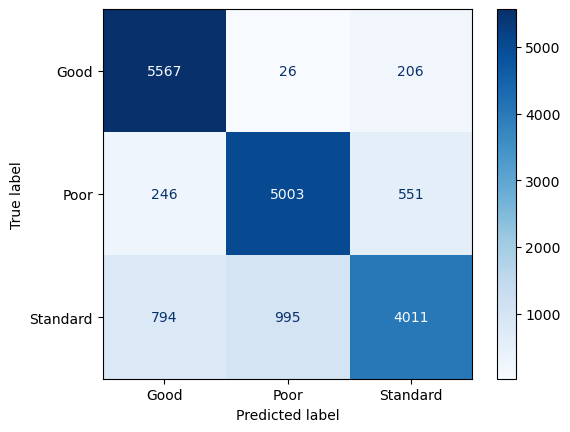

In [ ]:

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_encoder.classes_, cmap='Blues')


### Loss Function (Log-Loss)

In [ ]:

# Calculate probabilities for the test set
y_proba = best_rf.predict_proba(X_test)

# Compute log loss
loss = log_loss(y_test, y_proba)
print(f"Log Loss: {loss:.4f}")


Log Loss: 0.4393


In [ ]:
best_params = grid_search.best_params_  # Getting best parameters found by GridSearch

In [ ]:

# Initialize the Random Forest with the best hyperparameters

rf_tuned = RandomForestClassifier(**best_params, random_state=42, warm_start=True)

# Variables to store log losses
train_errors = []
test_errors = []

# Track log loss over estimators
for n_estimators in range(10, best_params['n_estimators'] + 1, 10):  # Increment estimators in steps of 10
    rf_tuned.set_params(n_estimators=n_estimators)  # Update the number of estimators
    rf_tuned.fit(X_train, y_train)

    # Predict probabilities for train and test sets
    y_train_proba = rf_tuned.predict_proba(X_train)
    y_test_proba = rf_tuned.predict_proba(X_test)

    # Calculate log loss
    train_log_loss = log_loss(y_train, y_train_proba)
    test_log_loss = log_loss(y_test, y_test_proba)

    train_errors.append(train_log_loss)
    test_errors.append(test_log_loss)


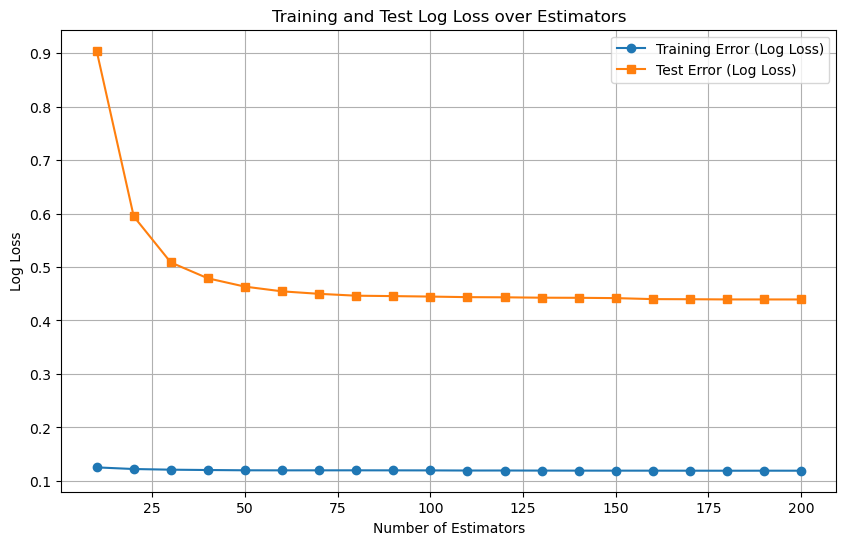

In [65]:
# Plot training and test errors
plt.figure(figsize=(10, 6))
plt.plot(range(10, best_params['n_estimators'] + 1, 10), train_errors, label='Training Error (Log Loss)', marker='o')
plt.plot(range(10, best_params['n_estimators'] + 1, 10), test_errors, label='Test Error (Log Loss)', marker='s')
plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.title('Training and Test Log Loss over Estimators')
plt.legend()
plt.grid()
plt.show()


### ROC Curve + AUC

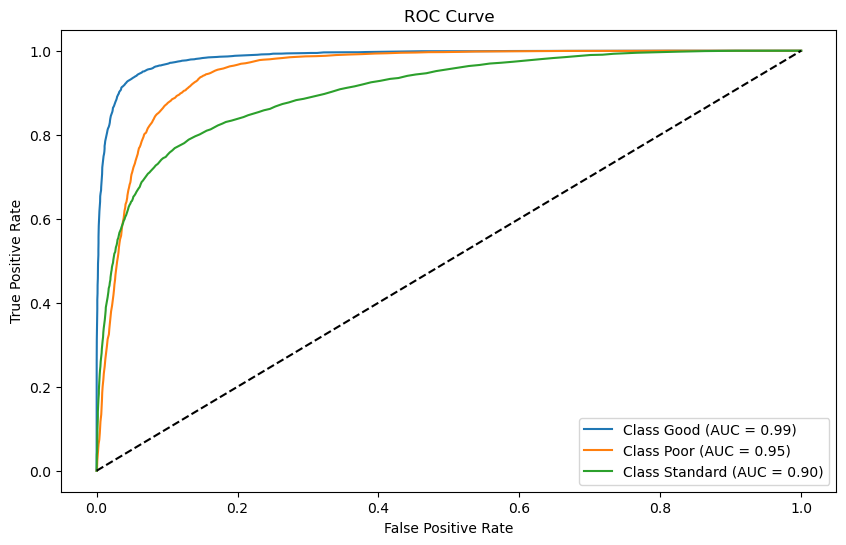

In [ ]:

# One-hot encode the target variable for ROC curve
y_test_onehot = pd.get_dummies(y_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_onehot.iloc[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


### Accuracy Score

In [ ]:

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.8380
